# The effect of review sentiment variance on game performance: a user and critic review perspective.

Before the preprocessing and analyses conducted below, we cleaned our dataset with regard to duplicates. Also, we filtered out all non-English reviews. Further preprocessing, analyses, methodological and regression steps are described in this notebook.

## Preproccesing

### Sentiment Analysis

In [ ]:
def vader_sentiment_to_df(dataframe):
    '''
        Gets the sentiment scores of reviews using nltk.sentiment.vader.
        
        Input: dataframe with reviews
        Output: original dataframe + column with sentiment score
    '''
    
    sid = SentimentIntensityAnalyzer()
    compound = []
    
    # iterate over dataframe and calculate sentiment scores per row
    for idx, row in dataframe.iterrows():
        
        scores = list(sid.polarity_scores(row['review']).values())
        
        comp = scores[3]
        
        compound.append(comp)
    
    # turns compound list into a dataframe
    compound_df = pd.DataFrame.from_dict({'compound':compound})
    
    # adds sentiment column to existing dataframe
    new_dataframe = pd.concat([dataframe, compound_df], axis = 1)
    
    # drops unnecessary columsn
    new_dataframe = new_dataframe.drop(columns = ['username', 'lang', 'helpful_nb', 'helpful_nb_total'])
    
    # renames compound column to match database
    new_dataframe.rename(columns={'compound':'sentiment'}, inplace=True)
    new_dataframe.rename(columns={'index':'id'}, inplace=True)
    
    return new_dataframe

##### Example Sentiment Analysis

In [5]:
### DataFrame Pre-Sentiment Analysis ###
reviews.head()

Loading from database


,game,username,date,grade,review,lang,helpful_nb,helpful_nb_total
0,007-legends-pc,Bughyman1000,2013-01-19,30,"Oh, my dear God! What is it with developers th...",en,0,0
1,007-legends-pc,DiabloZiri,2014-06-23,30,Seriously if you want to have a HUGE laugh wit...,en,0,0
2,007-legends-pc,DrugsMeazureTim,2014-12-11,0,godawful port of the xbox 360 version and ps3....,en,0,0
3,007-legends-pc,DustEater,2012-11-03,0,Agree. Worst game ever. Its a full copy of Cal...,en,8,8
4,007-legends-pc,evry1isacritic,2012-11-04,0,DO NOT BUY THIS GAME for the PC (or for any ot...,en,2,2


In [9]:
### DataFrame Post-Sentiment Analysis ###
new_df = vader_sentiment_to_df(reviews[0:5])
new_df.head()

,game,date,grade,review,sentiment
0,007-legends-pc,2013-01-19,30,"Oh, my dear God! What is it with developers th...",-0.9191
1,007-legends-pc,2014-06-23,30,Seriously if you want to have a HUGE laugh wit...,0.9424
2,007-legends-pc,2014-12-11,0,godawful port of the xbox 360 version and ps3....,-0.3869
3,007-legends-pc,2012-11-03,0,Agree. Worst game ever. Its a full copy of Cal...,-0.4854
4,007-legends-pc,2012-11-04,0,DO NOT BUY THIS GAME for the PC (or for any ot...,-0.9612


### Pre-Processing: Genre

In [ ]:
### Script to assign single genre to a game depending on frequency counts ###

# Get the genre frequency
genre_freq = df['genre'].value_counts().to_frame()

# Rest index
genre_freq.reset_index(inplace = True)

# Rename columns
genre_freq.rename(columns={'index' : 'genre', 'genre' : 'freq'}, inplace = True)

# Merge initial dataframe with the frequency counts for the genres
df = pd.merge(df, genre_freq).sort_values('game')

# Find indexes for each game-genre combination with the highest frequency
idx = df.groupby(['game'])['freq'].transform(max) == df['freq']

# Create new dataframe with the assigned genre for each game
final_df = df[idx].copy()

# Drop the frequency column
final_df.drop('freq', axis = 1, inplace = True)

##### Example

In [6]:
### Initial DataFrame - note that one game can belong to multiple genres

,game,genre
0,007-legends-pc,Action
1,007-legends-pc,Arcade
2,007-legends-pc,First-Person
3,007-legends-pc,Modern
4,007-legends-pc,Shooter


In [17]:
### Intermediate step: list total frequency for each genre

,game,genre,freq
0,007-legends-pc,Action,7691
12718,007-legends-pc,Shooter,2432
7691,007-legends-pc,Arcade,2224
9915,007-legends-pc,First-Person,1579
11494,007-legends-pc,Modern,1224


In [16]:
### Final step: select genre with highest frequency for each game

,game,genre
0,007-legends-pc,Action
1,007-legends-playstation-3,Action
2,007-legends-wii-u,Action
3,007-legends-xbox-360,Action
4,007-quantum-of-solace-ds,Action


## Data preparation for regression analysis

In [1]:
from toolbox import ToolBox
from tqdm import tqdm

from models import *

tqdm.pandas()

In [2]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
tb = ToolBox()

### Load user review data from database

In [4]:
df = tb.load_data_sql(table='user_reviews_clean', use_cache=True)
df = df[~df['review'].isnull()]
df.head()

Loaded from cache


,id,date,grade,game,review,sentiment
0,128002,2013-01-19,30,007-legends-pc,"Oh, my dear God! What is it with developers th...",-0.9191
1,128003,2014-06-23,30,007-legends-pc,Seriously if you want to have a HUGE laugh wit...,0.9424
2,128004,2014-12-11,0,007-legends-pc,godawful port of the xbox 360 version and ps3....,-0.3869
3,128005,2012-11-03,0,007-legends-pc,Agree. Worst game ever. Its a full copy of Cal...,0.5496
4,128006,2012-11-04,0,007-legends-pc,DO NOT BUY THIS GAME for the PC (or for any ot...,-0.9612


#### User review df processing

In [5]:
# getting the minimum review date of a game as proxy for release date
min_dates = pd.DataFrame(df.groupby('game', as_index=False).agg({'date': 'min'}))
min_dates.rename(columns={'date':'release_date'}, inplace=True)

In [6]:
# merge release date with df
df = pd.merge(df, min_dates, on='game')

In [7]:
df.head()

,id,date,grade,game,review,sentiment,release_date
0,128002,2013-01-19,30,007-legends-pc,"Oh, my dear God! What is it with developers th...",-0.9191,2012-11-03
1,128003,2014-06-23,30,007-legends-pc,Seriously if you want to have a HUGE laugh wit...,0.9424,2012-11-03
2,128004,2014-12-11,0,007-legends-pc,godawful port of the xbox 360 version and ps3....,-0.3869,2012-11-03
3,128005,2012-11-03,0,007-legends-pc,Agree. Worst game ever. Its a full copy of Cal...,0.5496,2012-11-03
4,128006,2012-11-04,0,007-legends-pc,DO NOT BUY THIS GAME for the PC (or for any ot...,-0.9612,2012-11-03


In [8]:
# define a function to calculate difference in weeks between release date and review date
def difference_weeks(date, release_date):
    date_dif=date-release_date
    weeks = math.floor(date_dif/np.timedelta64(1,'W'))
    return weeks

In [9]:
# apply function on each row in df
df['week'] = df.apply(lambda row: difference_weeks(row['date'], row['release_date']), axis=1)

In [10]:
df.head()

,id,date,grade,game,review,sentiment,release_date,week
0,128002,2013-01-19,30,007-legends-pc,"Oh, my dear God! What is it with developers th...",-0.9191,2012-11-03,11
1,128003,2014-06-23,30,007-legends-pc,Seriously if you want to have a HUGE laugh wit...,0.9424,2012-11-03,85
2,128004,2014-12-11,0,007-legends-pc,godawful port of the xbox 360 version and ps3....,-0.3869,2012-11-03,109
3,128005,2012-11-03,0,007-legends-pc,Agree. Worst game ever. Its a full copy of Cal...,0.5496,2012-11-03,0
4,128006,2012-11-04,0,007-legends-pc,DO NOT BUY THIS GAME for the PC (or for any ot...,-0.9612,2012-11-03,0


#### Further preprocessing - defining 2 timeframes

In [11]:
# Create timeframes of 3 weeks
df['timeframe'] = df['week'].apply(lambda week: week//3)

In [12]:
df.head()

,id,date,grade,game,review,sentiment,release_date,week,timeframe
0,128002,2013-01-19,30,007-legends-pc,"Oh, my dear God! What is it with developers th...",-0.9191,2012-11-03,11,3
1,128003,2014-06-23,30,007-legends-pc,Seriously if you want to have a HUGE laugh wit...,0.9424,2012-11-03,85,28
2,128004,2014-12-11,0,007-legends-pc,godawful port of the xbox 360 version and ps3....,-0.3869,2012-11-03,109,36
3,128005,2012-11-03,0,007-legends-pc,Agree. Worst game ever. Its a full copy of Cal...,0.5496,2012-11-03,0,0
4,128006,2012-11-04,0,007-legends-pc,DO NOT BUY THIS GAME for the PC (or for any ot...,-0.9612,2012-11-03,0,0


##### Calculate nr of reviews per timeframe

In [13]:
# empty matrix to define nr of reviews per timeframe  
reviews_per_timeframe = pd.DataFrame(np.zeros((len(df.groupby('game')), 2), dtype=np.int8), index=df.game.unique())

# enter reviews
for index, row in df[df['timeframe']<=1].iterrows():
    reviews_per_timeframe.loc[row['game'], row['timeframe']] += 1

reviews_per_timeframe.reset_index(inplace=True)
reviews_per_timeframe.rename(columns={'index': 'game'}, inplace=True)

In [14]:
# correlation between number of reviews in the first and second timeframe
reviews_per_timeframe.corr() 

,0,1
0,1.000000,0.676423
1,0.676423,1.000000


In [15]:
# create cross-sectional dataset from matrix
reviews_per_timeframe = reviews_per_timeframe.melt(id_vars=['game'], var_name='timeframe', value_name='nr_reviews')
reviews_per_timeframe.sort_values(['game', 'timeframe'], inplace=True)

In [16]:
reviews_per_timeframe.head()

,game,timeframe,nr_reviews
0,007-legends-pc,0,8
13068,007-legends-pc,1,0
1,007-legends-playstation-3,0,3
13069,007-legends-playstation-3,1,2
2,007-legends-wii-u,0,1


In [17]:
# calculate variables average grade and sentiment per timeframe
reviews_grouped = df.groupby(['game', 'timeframe'], as_index=False).agg({'grade': 'mean', 'sentiment': 'std'})
reviews_grouped.rename(columns={'grade': 'user_avg_grade', 'sentiment': 'user_sentiment_var'}, inplace=True)

In [18]:
# create cross-sectional dataset including average grade and sentiment per timeframe
user_reviews = pd.merge(reviews_per_timeframe, reviews_grouped, how='left', on=['game', 'timeframe'])

In [19]:
user_reviews.head()

,game,timeframe,nr_reviews,user_avg_grade,user_sentiment_var
0,007-legends-pc,0,8,13.75,0.744573
1,007-legends-pc,1,0,NaN,NaN
2,007-legends-playstation-3,0,3,40.00,0.950803
3,007-legends-playstation-3,1,2,15.00,0.460114
4,007-legends-wii-u,0,1,40.00,NaN


In [20]:
# create a lag of time variant independent variables
user_reviews_lagged = user_reviews
user_reviews_lagged[['user_avg_grade', 'user_sentiment_var']] = user_reviews.groupby(['game'])['user_avg_grade', 'user_sentiment_var'].shift(1)

In [21]:
user_reviews_lagged.head()

,game,timeframe,nr_reviews,user_avg_grade,user_sentiment_var
0,007-legends-pc,0,8,NaN,NaN
1,007-legends-pc,1,0,13.75,0.744573
2,007-legends-playstation-3,0,3,NaN,NaN
3,007-legends-playstation-3,1,2,40.00,0.950803
4,007-legends-wii-u,0,1,NaN,NaN


### Critic review df preprocessing

In [22]:
critics = pd.read_pickle('../../datasets/critic_review_clean.pkl')

In [23]:
critics.head()

,game,date,grade,review,sentiment
0,007-legends-pc,2012-12-03,35.0,"Unfortunately the game proves the fact, that d...",-0.3400
1,007-legends-pc,2012-12-21,30.0,The worst gift agent 007 could possibly get to...,-0.6399
2,007-legends-pc,2013-01-05,16.0,"Legends, you're the worst. [Feb 2013, p.79]",-0.6249
3,007-legends-pc,2013-02-06,28.0,"Why put yourself through this ordeal, when the...",0.0972
4,007-legends-pc,2013-01-29,25.0,007 Legends greets you with a warning that Act...,-0.7916


In [24]:
def critic_preprocessing(df):
    # create aggregated variables for each game
    reviews_grouped = df.groupby(['game'], as_index=False).agg({'grade': 'mean', 
                                                                'sentiment': 'std', 
                                                                'review': 'count'
                                                               })
    
    reviews_grouped.rename({'grade': 'critic_avg_grade', 
                            'sentiment': 'critic_sentiment_var',
                            'review': 'critic_volume'
                           }, inplace=True, axis=1)
    
    return reviews_grouped

In [25]:
critic_reviews = critic_preprocessing(critics)

In [26]:
critic_reviews.head()

,game,critic_avg_grade,critic_sentiment_var,critic_volume
0,007-legends-pc,26.800000,0.351563,5
1,007-legends-playstation-3,42.318182,0.619410,22
2,007-legends-wii-u,40.666667,0.080168,3
3,007-legends-xbox-360,46.448980,0.669014,49
4,007-quantum-of-solace-ds,64.300000,0.411520,10


### Create cross sectional dataframe - Count Models

In [27]:
# Read genre and console for each game from separate dataset
fields = ['game', 'genre', 'console']
genre_console = pd.read_csv('../../datasets/cross-sectional-data-with-control-variables.csv', usecols=fields)

In [46]:
# merge user and critic review dataframe
user_critics_cs = pd.merge(user_reviews_lagged, critic_reviews, how='left', on='game')

# merge review dataframe with control variables genre and console
df_cs = pd.merge(user_critics_cs, genre_console, how='left', on='game')

# filter rows with lagged independent variable
df_cs_count_models = df_cs[df_cs['timeframe']==1].drop(columns='timeframe')
df_cs_count_models.head()

,game,nr_reviews,user_avg_grade,user_sentiment_var,critic_avg_grade,critic_sentiment_var,critic_volume,genre,console
1,007-legends-pc,0,13.750000,0.744573,26.800000,0.351563,5.0,Action,pc
3,007-legends-playstation-3,2,40.000000,0.950803,42.318182,0.619410,22.0,Action,playstation-3
5,007-legends-wii-u,0,40.000000,NaN,40.666667,0.080168,3.0,Action,wii-u
7,007-legends-xbox-360,2,37.777778,0.707120,46.448980,0.669014,49.0,Action,xbox-360
9,007-quantum-of-solace-pc,1,30.000000,0.933805,70.833333,0.542889,18.0,Action,pc


In [29]:
# drop rows with null values
df_cs_count_models.dropna(how='any', inplace=True)
len(df_cs_count_models)

4610

### Control variables: genre and console

#### Genre

In [30]:
# Show distribution of genre over games in dataset
genre_counts = df_cs_count_models.genre.value_counts()
genre_counts

Action              1815
General              967
Role-Playing         441
Action Adventure     364
Sports               296
Simulation           205
Miscellaneous        176
Strategy             128
Arcade               106
Adventure             92
Puzzle                14
Racing                 5
Driving                1
Name: genre, dtype: int64

In [31]:
# Define dummy variable is_action = 1, when game is Action genre and 0 otherwise
df_cs_count_models['is_action'] = df_cs_count_models['genre'].apply(lambda genre: 1 if genre=='Action' else 0)

#### Console

In [32]:
# Show distribution of console over games in dataset
console_counts = df_cs_count_models.console.value_counts()
console_counts

pc                  1504
playstation-4        773
xbox-one             461
playstation-3        439
xbox-360             434
switch               338
3ds                  179
playstation-vita     157
wii-u                 98
wii                   67
ds                    40
playstation-2         31
psp                   25
game-boy-advance      14
gamecube              13
playstation           11
ios                   11
xbox                   8
nintendo-64            7
Name: console, dtype: int64

In [33]:
# Define dummy variable is_pc = 1, when game is PC game and 0 otherwise
df_cs_count_models['is_pc'] = df_cs_count_models['console'].apply(lambda console: 1 if console=='pc' else 0)
df_cs_count_models.head()

,game,nr_reviews,user_avg_grade,user_sentiment_var,critic_avg_grade,critic_sentiment_var,critic_volume,genre,console,is_action,is_pc
1,007-legends-pc,0,13.750000,0.744573,26.800000,0.351563,5.0,Action,pc,1,1
3,007-legends-playstation-3,2,40.000000,0.950803,42.318182,0.619410,22.0,Action,playstation-3,1,0
7,007-legends-xbox-360,2,37.777778,0.707120,46.448980,0.669014,49.0,Action,xbox-360,1,0
9,007-quantum-of-solace-pc,1,30.000000,0.933805,70.833333,0.542889,18.0,Action,pc,1,1
15,007-quantum-of-solace-xbox-360,0,95.000000,0.061165,67.043478,0.524897,69.0,Action,xbox-360,1,0


#### Descriptive Statistics Dataset Count Models

In [34]:
# Descriptive statistics
round(df_cs_count_models[['game', 'nr_reviews', 'user_sentiment_var', 'critic_sentiment_var', 'user_avg_grade', 'critic_avg_grade', 'critic_volume']].describe(),2)

,nr_reviews,user_sentiment_var,critic_sentiment_var,user_avg_grade,critic_avg_grade,critic_volume
count,4610.00,4610.00,4610.00,4610.00,4610.00,4610.00
mean,2.36,0.51,0.48,72.25,73.10,29.08
std,3.84,0.34,0.13,19.84,12.58,22.60
min,0.00,0.00,0.00,0.00,6.00,2.00
25%,0.00,0.15,0.40,61.43,66.86,11.00
50%,1.00,0.57,0.49,76.67,75.19,23.00
75%,3.00,0.76,0.56,87.04,81.91,41.00
max,108.00,1.41,1.15,100.00,98.95,129.00


In [35]:
# Correlations
round(df_cs_count_models[['game', 'nr_reviews', 'user_sentiment_var', 'critic_sentiment_var', 'user_avg_grade', 'critic_avg_grade', 'critic_volume']].corr(),2)

,nr_reviews,user_sentiment_var,critic_sentiment_var,user_avg_grade,critic_avg_grade,critic_volume
nr_reviews,1.00,0.14,0.05,-0.06,0.19,0.35
user_sentiment_var,0.14,1.00,0.13,-0.41,-0.13,0.06
critic_sentiment_var,0.05,0.13,1.00,-0.08,-0.19,0.05
user_avg_grade,-0.06,-0.41,-0.08,1.00,0.40,0.12
critic_avg_grade,0.19,-0.13,-0.19,0.40,1.00,0.32
critic_volume,0.35,0.06,0.05,0.12,0.32,1.00


In [36]:
# save df for regression analysis in R
df_cs_count_models.to_csv('../../datasets/final-df-count-models.csv', index=False)

### Dataframe for cross-sectional approach with minimum of 10 reviews per timeframe

In [60]:
# check minimum number of reviews over all periods for each game
games_min_reviews = df_cs.groupby(['game'], as_index=False).agg({'nr_reviews': 'min'})
games_min_reviews.rename(columns={'nr_reviews': 'min_reviews'}, inplace=True)

In [61]:
games_10_reviews = list(games_min_reviews[games_min_reviews['min_reviews']>=10]['game'])
len(games_10_reviews)

208

In [62]:
# filter all games with more than 10 reviews in each timeframe
df_cs_10_reviews = df_cs[df_cs['game'].isin(games_10_reviews)]

# filter rows with lagged independent variable
df_cs_10_reviews = df_cs_10_reviews[df_cs_10_reviews['timeframe']==1].drop(columns='timeframe')

In [69]:
# Define dummy variable is_action = 1, when game is Action genre and 0 otherwise
df_cs_10_reviews['is_action'] = df_cs_10_reviews['genre'].apply(lambda genre: 1 if genre=='Action' else 0)

# Define dummy variable is_pc = 1, when game is PC game and 0 otherwise
df_cs_10_reviews['is_pc'] = df_cs_10_reviews['console'].apply(lambda console: 1 if console=='pc' else 0)
df_cs_10_reviews.head()

,game,nr_reviews,user_avg_grade,user_sentiment_var,critic_avg_grade,critic_sentiment_var,critic_volume,genre,console,is_action,is_pc
199,a-hat-in-time-pc,11,90.416667,0.567230,79.282051,0.466825,41.0,Action,pc,1,1
217,a-plague-tale-innocence-pc,14,89.056604,0.459017,80.843750,0.552898,33.0,General,pc,0,1
219,a-plague-tale-innocence-playstation-4,12,86.610169,0.531837,82.491525,0.472003,63.0,General,playstation-4,0,0
695,aliens-colonial-marines-xbox-360,13,42.250000,0.811619,48.234043,0.639638,47.0,Action,xbox-360,1,0
813,amnesia-a-machine-for-pigs-pc,14,55.000000,0.793005,71.593220,0.607532,59.0,Action Adventure,pc,0,1


#### Descriptive Statistics Dataset OLS 

In [70]:
# Descriptive statistics
round(df_cs_10_reviews[['game', 'nr_reviews', 'user_sentiment_var', 'critic_sentiment_var', 'user_avg_grade', 'critic_avg_grade', 'critic_volume']].describe(),2)

,nr_reviews,user_sentiment_var,critic_sentiment_var,user_avg_grade,critic_avg_grade,critic_volume
count,208.00,208.00,208.00,208.00,208.00,208.00
mean,14.25,0.64,0.50,67.02,78.91,50.06
std,8.18,0.16,0.11,20.35,10.22,27.16
min,10.00,0.12,0.20,0.45,20.00,3.00
25%,10.00,0.57,0.41,56.29,74.40,29.00
50%,12.00,0.67,0.51,72.21,80.94,45.00
75%,15.00,0.75,0.58,82.71,85.60,70.25
max,108.00,0.90,0.79,96.50,97.09,129.00


In [71]:
# Correlations
round(df_cs_10_reviews[['game', 'nr_reviews', 'user_sentiment_var', 'critic_sentiment_var', 'user_avg_grade', 'critic_avg_grade', 'critic_volume']].corr(),2)

,nr_reviews,user_sentiment_var,critic_sentiment_var,user_avg_grade,critic_avg_grade,critic_volume
nr_reviews,1.00,0.00,0.13,-0.05,-0.10,0.16
user_sentiment_var,0.00,1.00,0.26,-0.53,-0.21,-0.15
critic_sentiment_var,0.13,0.26,1.00,-0.05,-0.33,-0.22
user_avg_grade,-0.05,-0.53,-0.05,1.00,0.43,0.21
critic_avg_grade,-0.10,-0.21,-0.33,0.43,1.00,0.22
critic_volume,0.16,-0.15,-0.22,0.21,0.22,1.00


In [72]:
# save df for regression analysis in R
df_cs_10_reviews.to_csv('../../datasets/final-df-cs-10-reviews.csv', index=False)

## Regression models
Regression analyses are conducted in R. Hence, the code below includes R programming language. 

In [ ]:
# Install necessary packages
install.packages("MASS")
library(MASS)
install.packages("pscl")
library(pscl)
install.packages("AER")
library(AER)
install.packages("countreg", repos="http://R-Forge.R-project.org")
library(countreg)

In [4]:
# Set options for scientific notation
options(scipen = 999)

### OLS Regression

In [5]:
# Read data for OLS model from file
data_OLS <- read.csv("../datasets/final-df-cs-10-reviews.csv")
OLS_model <- lm(nr_reviews ~ user_sentiment_var * critic_sentiment_var + user_avg_grade + critic_avg_grade + critic_volume + is_action + is_pc,
                data = data_OLS)
summary(OLS_model)


Call:
lm(formula = nr_reviews ~ user_sentiment_var * critic_sentiment_var + 
    user_avg_grade + critic_avg_grade + critic_volume + is_action + 
    is_pc, data = data_OLS)

Residuals:
   Min     1Q Median     3Q    Max 
-7.810 -3.992 -1.497  1.928 86.788 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                               0.040192  10.198064   0.004 0.996859
user_sentiment_var                       17.082243  13.391300   1.276 0.203576
critic_sentiment_var                     38.923849  17.152881   2.269 0.024327
user_avg_grade                           -0.033630   0.036650  -0.918 0.359944
critic_avg_grade                         -0.058485   0.065280  -0.896 0.371388
critic_volume                             0.084121   0.023340   3.604 0.000396
is_action                                -0.007419   1.148206  -0.006 0.994851
is_pc                                     1.523811   1.259833   1.210 0.227892
user_sentiment_

In [6]:
car::vif(OLS_model)

user_sentiment_var                    critic_sentiment_var 
                              14.807143                               10.620082 
                         user_avg_grade                        critic_avg_grade 
                               1.811523                                1.449711 
                          critic_volume                               is_action 
                               1.308714                                1.034817 
                                  is_pc user_sentiment_var:critic_sentiment_var 
                               1.190689                               29.087645

### Count models

In [8]:
# Read data for count models from file
data_count <- read.csv("../datasets/final-df-count-models.csv")

#### Poisson

In [9]:
poisson <- glm(nr_reviews ~ user_sentiment_var*critic_sentiment_var + user_avg_grade + critic_avg_grade + critic_volume + is_action + is_pc,
               data=data_count, family='poisson')

summary(poisson)


Call:
glm(formula = nr_reviews ~ user_sentiment_var * critic_sentiment_var + 
    user_avg_grade + critic_avg_grade + critic_volume + is_action + 
    is_pc, family = "poisson", data = data_count)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.8705  -1.6175  -0.7304   0.4856  18.2625  

Coefficients:
                                          Estimate Std. Error z value
(Intercept)                             -1.5596691  0.1157076 -13.479
user_sentiment_var                       0.3115651  0.1230791   2.531
critic_sentiment_var                     0.6957082  0.1638634   4.246
user_avg_grade                          -0.0092615  0.0005782 -16.018
critic_avg_grade                         0.0234270  0.0010508  22.294
critic_volume                            0.0182501  0.0003977  45.886
is_action                                0.0240622  0.0198634   1.211
is_pc                                    0.3148050  0.0214758  14.659
user_sentiment_var:critic_sentiment_var  0.

In [10]:
# Check VIF values (multicollinearity)
car::vif(poisson)

user_sentiment_var                    critic_sentiment_var 
                              17.479413                                3.692391 
                         user_avg_grade                        critic_avg_grade 
                               1.401794                                1.440046 
                          critic_volume                               is_action 
                               1.309462                                1.023536 
                                  is_pc user_sentiment_var:critic_sentiment_var 
                               1.154585                               21.784786

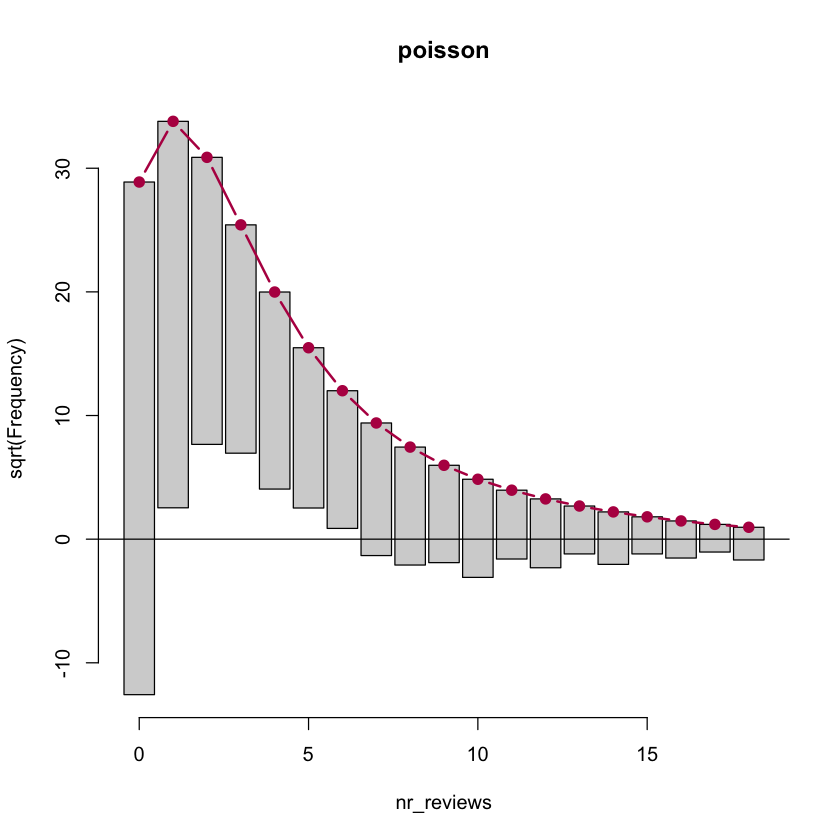

In [11]:
## Visualize fit
countreg::rootogram(poisson)

In [13]:
# Test for overdispersion (dispersion and alpha parameters)
dispersiontest(poisson)
dispersiontest(poisson, trafo=2)


	Overdispersion test

data:  poisson
z = 9.034, p-value < 0.00000000000000022
alternative hypothesis: true dispersion is greater than 1
sample estimates:
dispersion 
   4.19463 



	Overdispersion test

data:  poisson
z = 9.9259, p-value < 0.00000000000000022
alternative hypothesis: true alpha is greater than 0
sample estimates:
   alpha 
1.207467 


#### Negative Binomial

In [14]:
negbin <- glm.nb(nr_reviews ~ user_sentiment_var*critic_sentiment_var + user_avg_grade + critic_avg_grade + critic_volume + is_action + is_pc,
                 data=data_count)
summary(negbin)


Call:
glm.nb(formula = nr_reviews ~ user_sentiment_var * critic_sentiment_var + 
    user_avg_grade + critic_avg_grade + critic_volume + is_action + 
    is_pc, data = data_count, init.theta = 0.9075238355, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2739  -1.1882  -0.4185   0.2661   5.9280  

Coefficients:
                                          Estimate Std. Error z value
(Intercept)                             -1.8877496  0.2002006  -9.429
user_sentiment_var                       0.4433092  0.2148846   2.063
critic_sentiment_var                     0.5325350  0.2746050   1.939
user_avg_grade                          -0.0097128  0.0011618  -8.360
critic_avg_grade                         0.0259775  0.0019234  13.506
critic_volume                            0.0207325  0.0008832  23.474
is_action                                0.0783219  0.0393365   1.991
is_pc                                    0.3785777  0.0421972   8.972
user_sentiment_var:cr

In [15]:
# Check VIF values (multicollinearity)
car::vif(negbin)

user_sentiment_var                    critic_sentiment_var 
                              14.385529                                3.161223 
                         user_avg_grade                        critic_avg_grade 
                               1.436042                                1.411853 
                          critic_volume                               is_action 
                               1.221249                                1.020713 
                                  is_pc user_sentiment_var:critic_sentiment_var 
                               1.107824                               17.624595

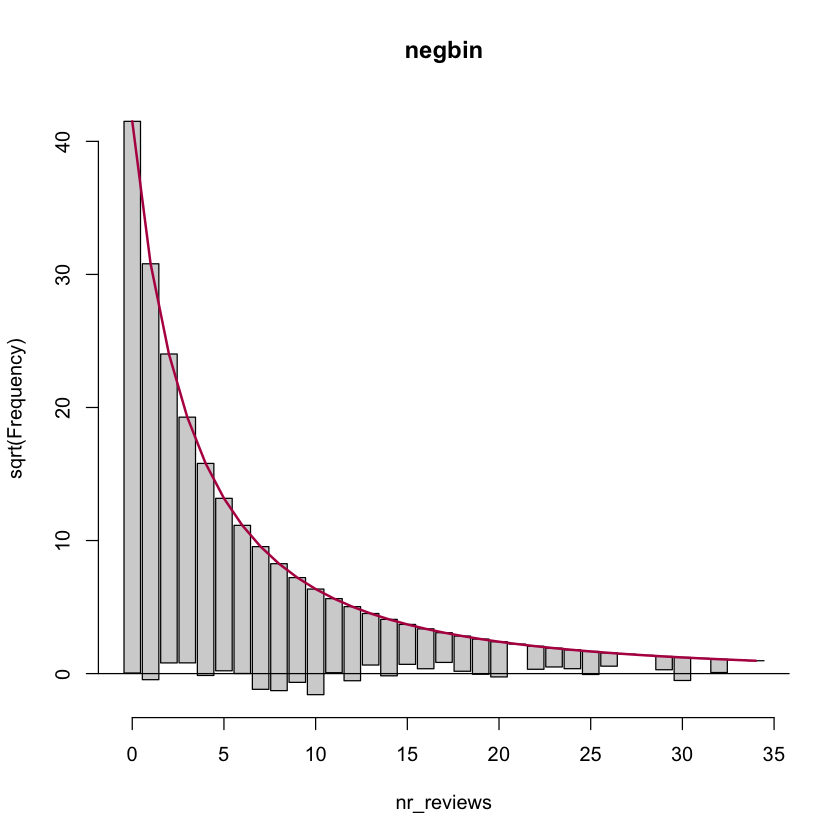

In [16]:
## Visualize fit
countreg::rootogram(negbin)

#### Hurdle Model

In [17]:
mod_hurdle <- hurdle(nr_reviews ~ user_sentiment_var * critic_sentiment_var + user_avg_grade + critic_avg_grade + critic_volume + is_action + is_pc,
                     data = data_count,
                     dist = "negbin")
summary(mod_hurdle)


Call:
hurdle(formula = nr_reviews ~ user_sentiment_var * critic_sentiment_var + 
    user_avg_grade + critic_avg_grade + critic_volume + is_action + is_pc, 
    data = data_count, dist = "negbin")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-0.9811 -0.6527 -0.3558  0.2933 20.8302 

Count model coefficients (truncated negbin with log link):
                                         Estimate Std. Error z value
(Intercept)                             -1.833808   0.298572  -6.142
user_sentiment_var                       0.811591   0.383089   2.119
critic_sentiment_var                     0.902744   0.464006   1.946
user_avg_grade                          -0.010368   0.001616  -6.416
critic_avg_grade                         0.024092   0.002357  10.222
critic_volume                            0.016312   0.001110  14.698
is_action                                0.065862   0.050597   1.302
is_pc                                    0.334048   0.054769   6.099
user_sentiment_var: